# Graph neural networks - Practicals 1

### [RUN] Installation of PyTorch

In [53]:
import torch
torch.manual_seed(0)
TORCH = torch.__version__.split('+')[0]
DEVICE = 'cu' + torch.version.cuda.replace('.', '') if torch.cuda.is_available() else 'cpu'

!pip install torch-sparse torch-scatter torch-cluster torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{DEVICE}.html
!pip install torch-geometric
!pip install networkx==3.1 matplotlib tqdm torchmetrics ipywidgets

import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torch_geometric.nn as gnn
import torch_geometric as tg
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
from typing import Tuple
from tqdm import tqdm

Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cpu.html


### [INFO 1] How are we training neural networks?


Recently, deep learning on graphs has emerged to one of the hottest research fields in the deep learning community.
Here, **Graph Neural Networks (GNNs)** aim to generalize classical deep learning concepts to irregular structured data (in contrast to images or texts) and to enable neural networks to reason about objects and their relations.

This is done by following a simple **neural message passing scheme**, where node features $\mathbf{x}_v^{(\ell)}$ of all nodes $v \in \mathcal{V}$ in a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ are iteratively updated by aggregating localized information from their neighbors $\mathcal{N}(v)$:

$$
\mathbf{x}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_v^{(\ell)}, \left\{ \mathbf{x}_w^{(\ell)} : w \in \mathcal{N}(v) \right\} \right)
$$

This tutorial will introduce you to some fundamental concepts regarding deep learning on graphs via Graph Neural Networks based on the **[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)**.
PyTorch Geometric is an extension library to the popular deep learning framework [PyTorch](https://pytorch.org/), and consists of various methods and utilities to ease the implementation of Graph Neural Networks.


### Download training data

**Datasets**

Comparing to other Fully-Connected Neural Networks (NNs) or Convolutional Neural Networks (CNNs),

Graph neural networks (GNNs) require have two basic datapoints: a graph structure and a feature matrix.

In [56]:
from torch_geometric.datasets import TUDataset

def reduce_features(data):
    data.x = data.x.sum(dim=1, keepdim=True)
    return data

dataset = TUDataset(root='data/TUDataset', name='MUTAG', pre_transform=reduce_features)

### [INFO 3] Explore dataset

The most common task for graph classification is **molecular property prediction**, in which molecules are represented as graphs, and the task may be to infer whether a molecule inhibits HIV virus replication or not.

The TU Dortmund University has collected a wide range of different graph classification datasets, known as the [**TUDatasets**](https://chrsmrrs.github.io/datasets/), which are also accessible via [`torch_geometric.datasets.TUDataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset) in PyTorch Geometric.
Let's load and inspect one of the smaller ones, the **MUTAG dataset**:

In [57]:
# from ipywidgets import interact, IntSlider

# @interact(index=IntSlider())
# def display_dataset_element(index):
#     g = to_networkx(dataset[index], to_undirected=True)
#     plt.title(f"Class: {dataset[index].y.item()}")
#     nx.draw(g, with_labels=True)
#     plt.show()

## [INFO 2] Mini-batching of graphs

Since graphs in graph classification datasets are usually small, a good idea is to **batch the graphs** before inputting them into a Graph Neural Network to guarantee full GPU utilization.
In the image or language domain, this procedure is typically achieved by **rescaling** or **padding** each example into a set of equally-sized shapes, and examples are then grouped in an additional dimension.
The length of this dimension is then equal to the number of examples grouped in a mini-batch and is typically referred to as the `batch_size`.

However, for GNNs the two approaches described above are either not feasible or may result in a lot of unnecessary memory consumption.
Therefore, PyTorch Geometric opts for another approach to achieve parallelization across a number of examples. Here, adjacency matrices are stacked in a diagonal fashion (creating a giant graph that holds multiple isolated subgraphs), and node and target features are simply concatenated in the node dimension:

This procedure has some crucial advantages over other batching procedures:

1. GNN operators that rely on a message passing scheme do not need to be modified since messages are not exchanged between two nodes that belong to different graphs.

2. There is no computational or memory overhead since adjacency matrices are saved in a sparse fashion holding only non-zero entries, *i.e.*, the edges.

PyTorch Geometric automatically takes care of **batching multiple graphs into a single giant graph** with the help of the [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) class.

## [INFO 3] Graph Classification with Graph Neural Networks


In this tutorial session we will have a closer look at how to apply **Graph Neural Networks (GNNs) to the task of graph classification**.
Graph classification refers to the problem of classifiying entire graphs (in contrast to nodes), given a **dataset of graphs**, based on some structural graph properties.
Here, we want to embed entire graphs, and we want to embed those graphs in such a way so that they are linearly separable given a task at hand.

## Training a Graph Neural Network (GNN)

Training a GNN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

The final architecture for applying GNNs to the task of graph classification then looks as follows and allows for complete end-to-end training:

In [ ]:

def train_and_eval(model : nn.Module, dataset : Dataset, hparams: dict = {}) -> Tuple[nn.Module, float]:
    """
    Train and evaluate the model on the dataset.
    A boilerplate for training and evaluating a neural network.

    Args:
        model (nn.Module): The model to train and evaluate.
        dataset (Dataset): The dataset to train and evaluate on.
        hparams (dict): A dictionary of hyperparameters.

    Returns:
        nn.Module: The trained model with the best validation accuracy.
        float: The best validation accuracy.
    """

    hparams["num_epochs"] = hparams.get("num_epochs", 200)
    hparams["lr"] = hparams.get("lr", 0.01)

    # shuffle dataset
    dataset = dataset.shuffle()
    train_sizes = {"ENZYMES": 540, "MUTAG": 150}
    sz = train_sizes[dataset.name]
    
    # init training and validation dataloaders
    dataloader_train = DataLoader(dataset[:sz], batch_size=16, shuffle=True)
    dataloader_val = DataLoader(dataset[sz:], batch_size=16)

    # init optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams["lr"])
    criterion = nn.CrossEntropyLoss()

    # init metrics
    metric_loss_train = torchmetrics.MeanMetric()
    metric_accuracy_train = torchmetrics.Accuracy(task="multiclass", num_classes=dataset.num_classes)
    metric_accuracy_val = torchmetrics.Accuracy(task="multiclass", num_classes=dataset.num_classes)

    best_model_state = None
    best_val_acc = 0.0

    # training loop
    num_epochs = hparams["num_epochs"]
    epoch_bar = tqdm(list(range(num_epochs)), desc="Epochs" + " "*100)
    for epoch in epoch_bar:

        # training loop
        model.train()
        for data in dataloader_train:
            optimizer.zero_grad()
            logits = model(data.x, data.edge_index, data.batch)
            loss = criterion(logits, data.y)
            loss.backward()
            optimizer.step()

            metric_loss_train(loss)
            metric_accuracy_train(logits.argmax(dim=1), data.y)


        # evaluation loop
        model.eval()
        for data in dataloader_val:
            with torch.no_grad():
                logits = model(data.x, data.edge_index, data.batch)
                pred = logits.argmax(dim=1)
                metric_accuracy_val(pred, data.y)

        train_loss = metric_loss_train.compute().item()
        train_acc = metric_accuracy_train.compute().item()
        val_acc = metric_accuracy_val.compute().item()

        # progress bar
        epoch_bar.set_description("".join([
            f'Epoch: {epoch+1:03d} | ',
            f'Val Acc: {val_acc:.3f} | ',
            f'Train Acc: {train_acc:.3f} | ',
            f'Train Loss: {train_loss:.3f} | ',
            ]))

        # update best model
        if val_acc > best_val_acc:
            best_model_state = model.state_dict()
            best_val_acc = val_acc

    best_model = model
    best_model.load_state_dict(best_model_state)

    return best_model, best_val_acc

### Define our model

We will use the `nn.Module` class from PyTorch to define our model.
Since having multiple datapoints we need to define a model that has multiple inputs in the `forward` function.



In [5]:
class SetConv(nn.Linear): 
    """
    A simple linear layer that performs action on every node feature
    """

    def forward(self, x, edge_index): 
        return super().forward(x)


class GraphNetModel(nn.Module):

    def __init__(self, num_features, num_classes, conv_layer_cls=None):
        super().__init__()

        # in case no gnnLayer is provided, use a simple linear layer
        if conv_layer_cls is None:
            conv_layer_cls = SetConv

        # first graph covolutional layer
        self.conv1 = conv_layer_cls(num_features, 32)
        self.conv2 = conv_layer_cls(32, 32)
        self.conv3 = conv_layer_cls(32, 32)
        # TODO🚀(optional):
        # - add more conv layers

        # last graph convolutional layer
        self.convL = conv_layer_cls(32, 32)

        # TODO🚀(optional):
        # - in many tutorials, the stantard dropout layer
        #    on **features** is used which can help
        #    with overfitting. Simlarly, the standard
        #    batch normalization can be used as well.
        # - `self.dropout = nn.Dropout(0.5)`

        # TODO🚀(optional):
        # - you might try to add batchnorm on features
        #   between the conv layers
        # - `self.batchnorm = nn.BatchNorm1d(32)`

        self.linear = nn.Linear(32, num_classes)

    def forward(self, x, edge_index, batch):

        # apply first layer and follow with ReLU
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        
        # TODO🚀(optional):
        # - apply more conv layers

        x = self.convL(x, edge_index).relu()

        # this (set) pooling makes the function
        # invariant to the order of the nodes
        x = gnn.global_mean_pool(x, batch)

        # TODO🚀(optional):
        # add dropout or batchnorm of features
        # - `x = self.dropout(x)`

        # apply linear layer
        x = self.linear(x)

        return x

### Perform training and evaluation

In [6]:
model = GraphNetModel(dataset.num_features, dataset.num_classes)
model, val_accuracy = train_and_eval(model, dataset)

print("Model size:", sum(p.numel() for p in model.parameters()))
print("Validation Accuracy:", val_accuracy)

Epoch: 001 | Val Acc: 0.632 | Train Acc: 0.673 | Train Loss: 0.635 | :   0%|          | 1/200 [00:00<00:20,  9.77it/s]                             

Epoch: 200 | Val Acc: 0.632 | Train Acc: 0.673 | Train Loss: 0.633 | : 100%|██████████| 200/200 [00:15<00:00, 12.57it/s]

Model size: 3298
Validation Accuracy: 0.6315789222717285


### [Task 1]:

$$
\begin{align}
F^{(t+1)} &= \sigma(F^{(t)} W_1^{(t)} + A F^{(t)} W_2^{(t)} + b^{(t)})
\end{align}
$$

In [7]:
class OurGraphConvLayer(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.linear1 = nn.Linear(in_channels, out_channels)
        self.linear2 = nn.Linear(in_channels, out_channels, bias=False)
    
    def forward(self, x, edge_index):
        nx = x.shape[0]

        # create abstraction of sparse adjacency matrix from edge_index
        A = torch.sparse_coo_tensor(edge_index, torch.ones_like(edge_index[0]).float(), size=(nx, nx))
        

        W1 = self.linear1.weight.T
        W2 = self.linear2.weight.T
        b = self.linear1.bias

        out = x @ W1 + A @ x @ W2 + b
        return out

**train model with GraphConv Layer:**

In [42]:
model_our1 = GraphNetModel(dataset.num_features, dataset.num_classes, conv_layer_cls=OurGraphConvLayer)
trained_model_our1, val_accuracy_our1 = train_and_eval(model_our1, dataset)

print("Model size:", sum(p.numel() for p in model_our1.parameters()))
print("Validation Accuracy:", val_accuracy_our1)

Epoch: 200 | Val Acc: 0.861 | Train Acc: 0.843 | Train Loss: 0.331 | : 100%|██████████| 200/200 [00:22<00:00,  9.09it/s]                           

Model size: 6402
Validation Accuracy: 0.8613157868385315


### [Task 2] Implementing the (simple) Graph Convolutional Layer (GCN)


$$
\begin{align}
\hat{D} &= D + I \\
\hat{A} &= A + I \\
\tilde{A} &= \hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2} \\
F^{(t+1)} &= \sigma(\tilde{A} F^{(t)} W^{(t)} + b^{(t)})
\end{align}
$$

In [ ]:
class OurGCNLayer(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        # initialize linear layer with weight `W` and bias `b`
        self.linear = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        nx = x.shape[0]

        # create abstraction of sparse adjacency matrix from edge_index
        A = tg.utils.to_torch_coo_tensor(edge_index)

        # also sparse identity matrix
        I = torch.sparse_coo_tensor(torch.stack([torch.arange(nx), torch.arange(nx)]), torch.ones(nx).float(), size=(nx, nx))

        # add self-loops
        A_hat = A + 2*I

        # degree vector
        deg_inv_sqrt = A_hat.sum(dim=1).to_dense().pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0.0

        # normalized inverse degree matrix
        Di = I * deg_inv_sqrt
        assert Di.is_sparse

        # using bias and weight of linear layer
        W = self.linear.weight.T
        b = self.linear.bias

        # normalize adjacency matrix
        A_norm = Di @ A_hat @ Di
        assert A_norm.is_sparse

        x = A_norm @ x @ W + b
        return x


In [43]:
model_our2 = GraphNetModel(dataset.num_features, dataset.num_classes, conv_layer_cls=OurGCNLayer)
trained_model_our2, val_accuracy_our2 = train_and_eval(model_our2, dataset)

print("Model size:", sum(p.numel() for p in model_our2.parameters()))
print("Validation Accuracy:", val_accuracy_our2)

Epoch: 200 | Val Acc: 0.579 | Train Acc: 0.687 | Train Loss: 0.622 | : 100%|██████████| 200/200 [00:29<00:00,  6.73it/s]                           

Model size: 3298
Validation Accuracy: 0.5789473652839661


### But what structures are our models really capturing?

Consider the following graphs:

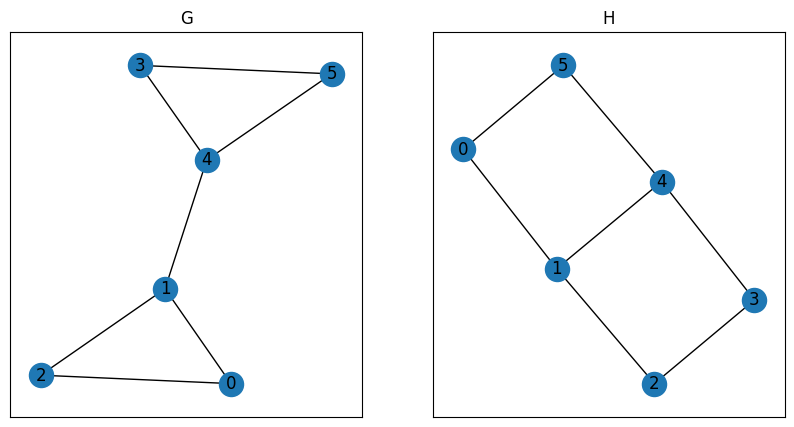

In [26]:
graph_G = nx.from_edgelist([(0,1), (1,2), (2,0), (3,4), (4,5), (5,3), (1,4)])
graph_H = nx.from_edgelist([(0,1), (1,2), (2,3), (3,4), (4,5), (5,0), (1,4)])

plt.subplots(1,2, figsize=(10,5))
plt.subplot(121)
plt.title("G")
nx.draw_networkx(graph_G)
plt.subplot(122)
plt.title("H")
nx.draw_networkx(graph_H)
plt.show()

### So why are outputs identical if the graphs are clearly not isomorphic?
"... because of 1-WL"

In [47]:
model_our1.eval()

def from_networkx(G: nx.Graph) -> tg.data.Data:
    """Utility function"""
    data = tg.utils.from_networkx(G)
    data.x = torch.ones((G.number_of_nodes(), 1), dtype=torch.float)
    return data

# simple features to test the model
data_G = from_networkx(graph_G)
data_H = from_networkx(graph_H)
batch = torch.zeros(6).long()

logits_G = model_our1(data_G.x, data_G.edge_index, batch)
logits_H = model_our1(data_H.x, data_H.edge_index, batch)

print("Prediction for G: ", logits_G.detach().numpy())
print("Prediction for H:", logits_H.detach().numpy())

Prediction for G:  [[-2.4425356  1.5812643]]
Prediction for H: [[-2.4425356  1.5812643]]


### However,

we can still try to break this symetry by permutation invariant operations such as node deletion.
Clearly, the following sets of graphs are not even have the same degree sequences.

In [48]:
def graph_into_subgraphs(data):
    n, m = len(data.x), len(data.edge_index[0])
    data.x = torch.cat([data.x.repeat(n, 1), torch.eye(n).view(-1, 1)], dim=1)
    data.edge_index = data.edge_index.repeat(1, n) + n*torch.arange(n).repeat_interleave(m)
    return data


### Demonstrate 

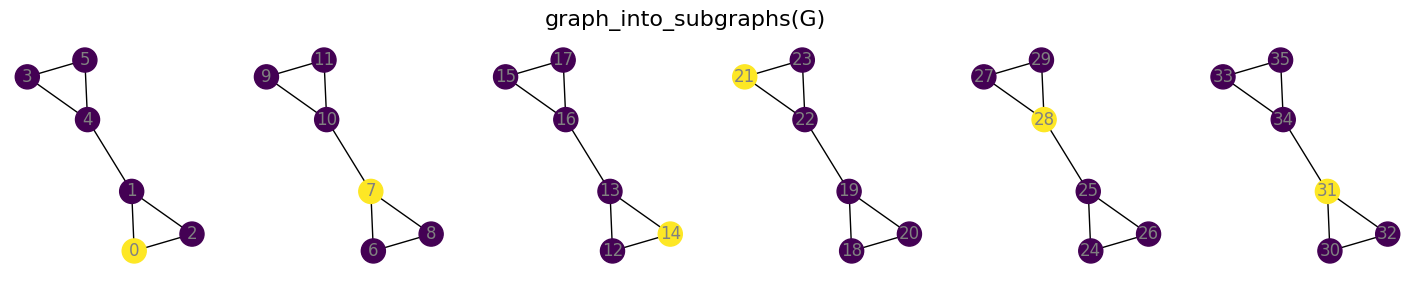

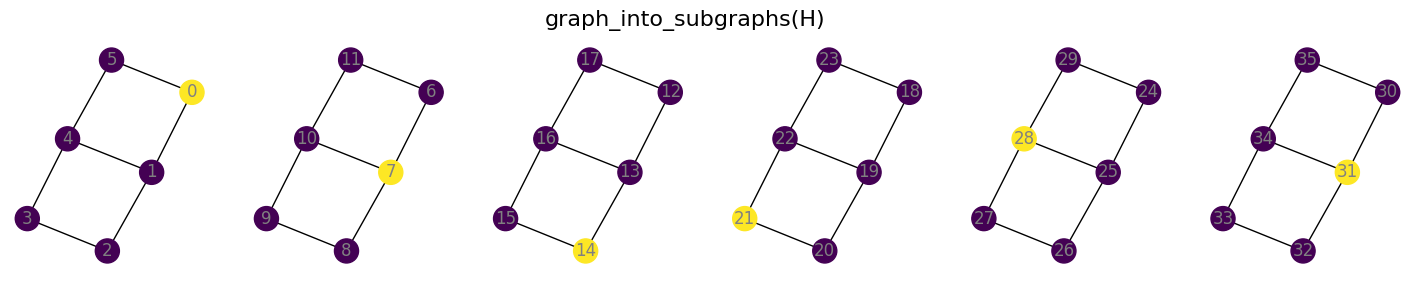

In [49]:
def draw_graph_with_aligned_components(graph, name):
    # fix layout for visualization
    pos = nx.spring_layout(graph, seed=42)

    n = graph.number_of_nodes()
    data = from_networkx(graph)
    data.x = torch.ones(len(graph), 1)
    bagged_data = graph_into_subgraphs(data)
    bagged_graph = to_networkx(bagged_data, to_undirected=True)
    plt.subplots(1,6, figsize=(3*n,3))
    plt.suptitle(name, fontsize=16)
    for i, conn_comp in enumerate(nx.connected_components(bagged_graph)):
        plt.subplot(1,6,i+1)
        conn_g = bagged_graph.subgraph(conn_comp)
        nodes = sorted(conn_comp)
        pos_updated = {k: pos[j] for j, k in enumerate(nodes)}
        marks = bagged_data.x[torch.LongTensor(nodes), -1]
        nx.draw_networkx(conn_g, with_labels=True, node_color=marks, font_color='gray', pos=pos_updated)
        plt.axis('off')
    plt.show()



draw_graph_with_aligned_components(graph_G, "graph_into_subgraphs(G)")
draw_graph_with_aligned_components(graph_H, "graph_into_subgraphs(H)")


In [50]:
# Add this transform to dataset
bagged_dataset = TUDataset(root='data/TUDataset', name='MUTAG', pre_transform=reduce_features, transform=graph_into_subgraphs)

In [51]:
model_our_bagged = GraphNetModel(bagged_dataset.num_features, bagged_dataset.num_classes, OurGCNLayer)
trained_model_our_bagged, val_accuracy_our_bagged = train_and_eval(model_our_bagged, bagged_dataset)

print("Model size:", sum(p.numel() for p in model_our_bagged.parameters()))
print("Validation Accuracy:", val_accuracy_our_bagged)

Epoch: 200 | Val Acc: 0.807 | Train Acc: 0.820 | Train Loss: 0.425 | : 100%|██████████| 200/200 [01:49<00:00,  1.83it/s]                           

Model size: 3330
Validation Accuracy: 0.8072368502616882


Hey! Now our model not only has a better accuracy, but also is

### More expressive ?!

In [52]:
model_our_bagged.eval()

# simple features to test the model
data_G = graph_into_subgraphs(from_networkx(graph_G))
data_H = graph_into_subgraphs(from_networkx(graph_H))
batch = torch.zeros(len(data_G.x)).long()

logits_G = model_our_bagged(data_G.x, data_G.edge_index, batch)
logits_H = model_our_bagged(data_H.x, data_H.edge_index, batch)

print("Prediction for G: ", logits_G.detach().numpy())
print("Prediction for H:", logits_H.detach().numpy())

Prediction for G:  [[ 5.1602592 -7.094205 ]]
Prediction for H: [[ 4.464724 -5.952507]]


[*] INFO1- parts were adapted from [PyG Colab Tutorial](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html), please visit for more information.